In [1]:
import numpy as np
import pandas as pd
import datetime

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

pd.options.display.max_columns = 300

/Users/narimatsu_n/.pyenv/versions/3.5.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_train = pd.read_csv('../input/train_20190217.csv')
df_test = pd.read_csv('../input/test_201917.csv')

In [3]:
def merge_new_feature(path, use=[]):
    if len(use) > 1:
        df_new_feature = pd.read_csv(path, usecols=use)
    else:
        df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [4]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_count_merchants_of_zero_target.csv")
df_train, df_test = merge_new_feature("../input/feature_increase_rate_purchase_amount.csv")

In [5]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [6]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [7]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.8:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【feature_1】 --- 【feature】
0.8639071684847469



【hist_month_nunique】 --- 【hist_weekofyear_nunique】
0.8298919857872735



【hist_month_nunique】 --- 【hist_purchase_date_diff】
0.890100962939275



【hist_month_nunique】 --- 【elapsed_from_oldest_purchase_date_to_latest_purchase_date】
0.8599107762595712



【hist_subsector_id_nunique】 --- 【hist_merchant_id_nunique】
0.8468466681754612



【hist_subsector_id_nunique】 --- 【hist_merchant_category_id_nunique】
0.9415358313591881



【hist_merchant_id_nunique】 --- 【hist_merchant_category_id_nunique】
0.9242773351660543



【hist_merchant_id_nunique】 --- 【hist_authorized_flag_sum】
0.8656714340641819



【hist_merchant_id_nunique】 --- 【hist_weekend_sum】
0.8151881994831011



【hist_merchant_id_nunique】 --- 【hist_card_id_size】
0.8594477906127703



【hist_merchant_id_nunique】 --- 【card_id_count】
0.8695510406092224



【hist_merchant_id_nunique】 --- 【authorized_flag_ture】
0.8754282183453568



【hist_merchant_id_nunique】 --- 【authorized_flag_ture_weighted_elapsed】

【most_recent_sales_range_D】 --- 【most_recent_sales_range_D_weighted_elapsed】
0.8495492114152764



【most_recent_sales_range_E】 --- 【most_recent_sales_range_E_weighted_elapsed】
0.8261388455482708



【most_recent_sales_range_A_rate】 --- 【most_recent_purchases_range_A_rate】
0.9084786091093131



【most_recent_purchases_range_A】 --- 【most_recent_sales_range_A_weighted_elapsed】
0.8250874170449652



【most_recent_purchases_range_A】 --- 【most_recent_purchases_range_A_weighted_elapsed】
0.8710233115785021



【most_recent_purchases_range_B】 --- 【most_recent_purchases_range_B_weighted_elapsed】
0.8574486986409431



【most_recent_purchases_range_C】 --- 【most_recent_purchases_range_C_weighted_elapsed】
0.8489609324333489



【most_recent_purchases_range_D】 --- 【most_recent_purchases_range_D_weighted_elapsed】
0.8434293813931019



【most_recent_purchases_range_E】 --- 【most_recent_purchases_range_E_weighted_elapsed】
0.8206398650545965



【payment_splited_by_installments_NMF_3】 --- 【month_lag_N1_weighted_e

In [8]:
sorted(set(drop_col))

['authorized_flag_ture',
 'authorized_flag_ture_rate',
 'authorized_flag_ture_weighted_elapsed',
 'card_id_count',
 'category_1_true',
 'category_1_true_rate',
 'category_1_true_weighted_elapsed',
 'category_2_1_weighted_elapsed',
 'category_2_2_weighted_elapsed',
 'category_2_3_weighted_elapsed',
 'category_2_4_weighted_elapsed',
 'category_2_5_weighted_elapsed',
 'category_3_A_latest_trs',
 'category_3_A_rate',
 'category_3_A_weighted_elapsed',
 'category_3_B',
 'category_3_B_weighted_elapsed',
 'category_3_C_weighted_elapsed',
 'category_4_true_weighted_elapsed',
 'elapsed_from_latest_purchase_date',
 'elapsed_from_oldest_purchase_date_to_first_active',
 'elapsed_from_oldest_purchase_date_to_latest_purchase_date',
 'feature',
 'hist_authorized_flag_mean__div__hist_category_1_sum',
 'hist_authorized_flag_mean__div__hist_month_lag_mean',
 'hist_authorized_flag_sum',
 'hist_card_id_size',
 'hist_first_buy',
 'hist_merchant_category_id_nunique',
 'hist_merchant_id_nunique',
 'hist_month

In [9]:
len(df_train_columns)

242

In [10]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.7296012043929662,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.90991	valid_1's auc: 0.896349
[200]	training's auc: 0.924822	valid_1's auc: 0.900351
[300]	training's auc: 0.93557	valid_1's auc: 0.901462
[400]	training's auc: 0.944729	valid_1's auc: 0.901699
[500]	training's auc: 0.952525	valid_1's auc: 0.902552
[600]	training's auc: 0.960306	valid_1's auc: 0.903767
[700]	training's auc: 0.966132	valid_1's auc: 0.904152
Early stopping, best iteration is:
[680]	training's auc: 0.964967	valid_1's auc: 0.904216
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.909883	valid_1's auc: 0.877805
[200]	training's auc: 0.927705	valid_1's auc: 0.887856
[300]	training's auc: 0.937342	valid_1's auc: 0.889745
[400]	training's auc: 0.945599	valid_1's auc: 0.891858
[500]	training's auc: 0.953097	valid_1's auc: 0.893151
[600]	training's auc: 0.960594	valid_1's auc: 0.894335
[700]	training's auc: 0.966762	valid_1's auc: 0.894905
[8

0.9020012139487168

In [11]:
#0.9013241810502891

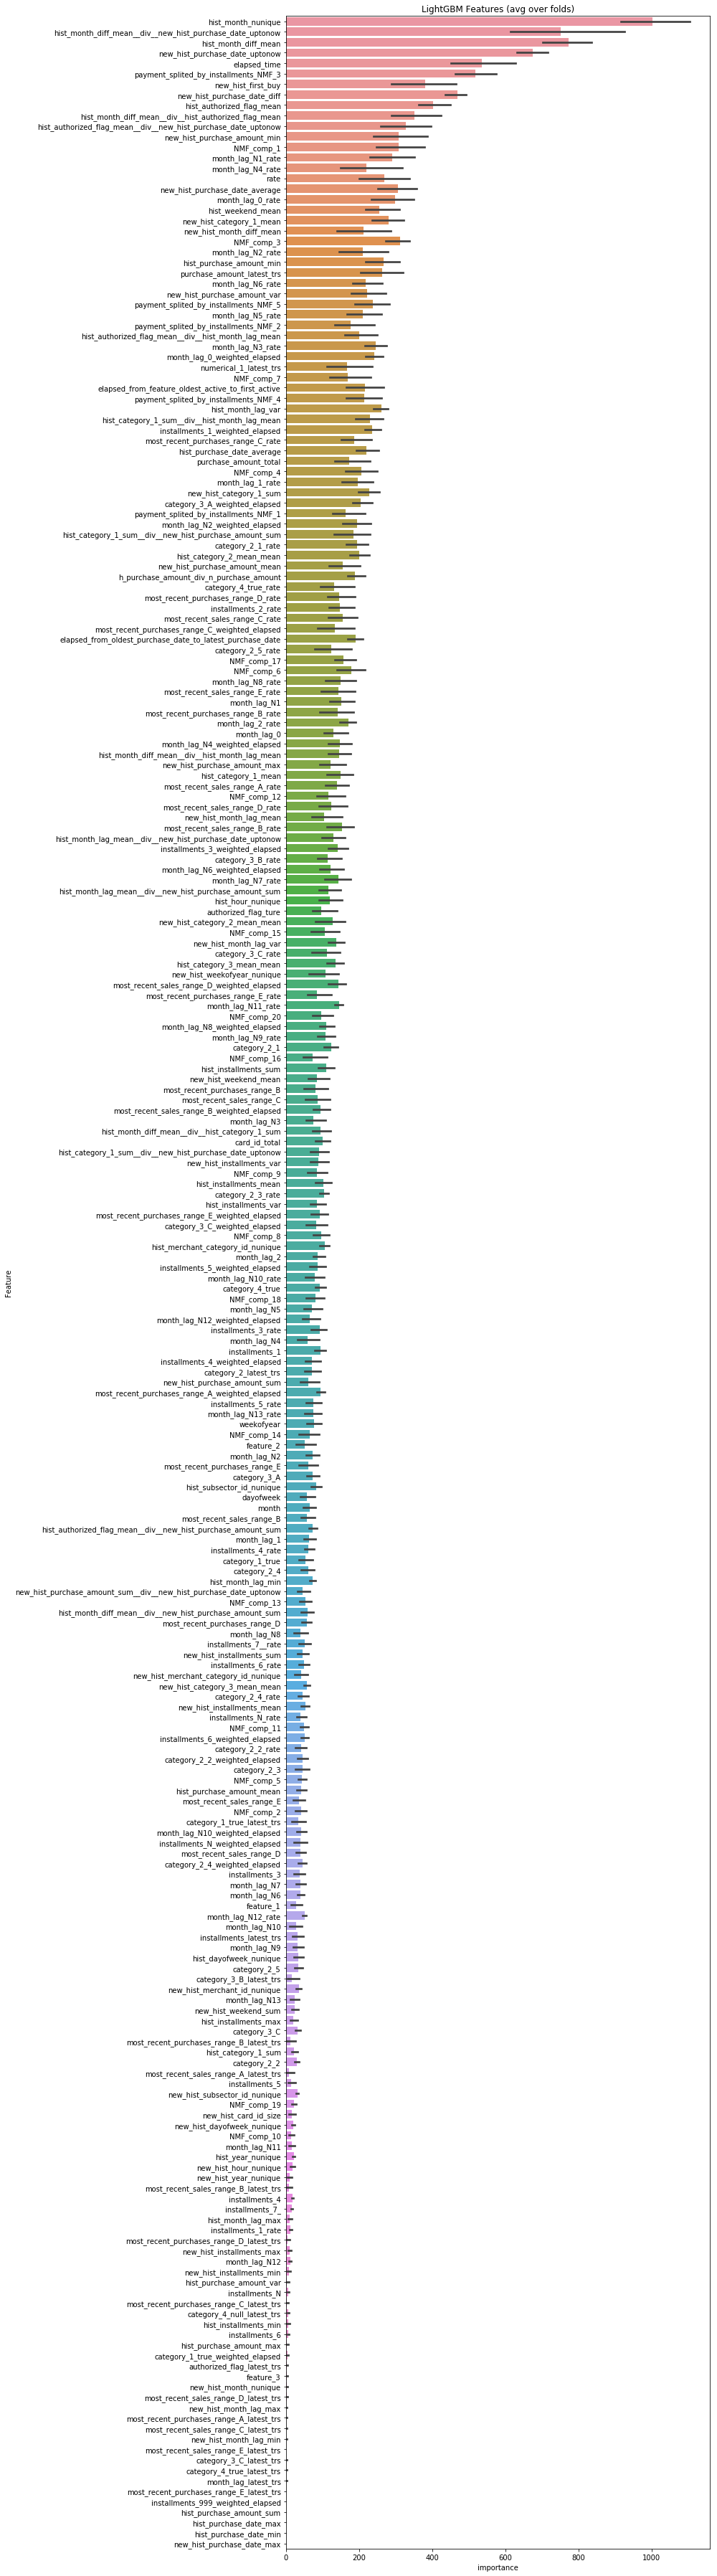

In [12]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [13]:
df_train_columns2 = cols[:200]

#original
param = {
    'num_leaves': 31, 
    'min_data_in_leaf': 30,
    'objective':'binary', 
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'auc',
    "lambda_l1": 0.7296012043929662,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.90994	valid_1's auc: 0.898048
[200]	training's auc: 0.925563	valid_1's auc: 0.900367
[300]	training's auc: 0.935452	valid_1's auc: 0.901912
[400]	training's auc: 0.944319	valid_1's auc: 0.902455
[500]	training's auc: 0.952165	valid_1's auc: 0.903256
[600]	training's auc: 0.959568	valid_1's auc: 0.904286
[700]	training's auc: 0.965783	valid_1's auc: 0.904581
[800]	training's auc: 0.970329	valid_1's auc: 0.904262
[900]	training's auc: 0.973666	valid_1's auc: 0.90409
[1000]	training's auc: 0.976731	valid_1's auc: 0.904212
[1100]	training's auc: 0.979311	valid_1's auc: 0.9041
Early stopping, best iteration is:
[702]	training's auc: 0.965855	valid_1's auc: 0.90461
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911814	valid_1's auc: 0.882675
[200]	training's auc: 0.927227	valid_1's auc: 0.888207
[300]	training's auc: 0.936579	valid_1's auc: 0.890437
[40

0.9019332427125811

In [14]:
#0.9018406934731391

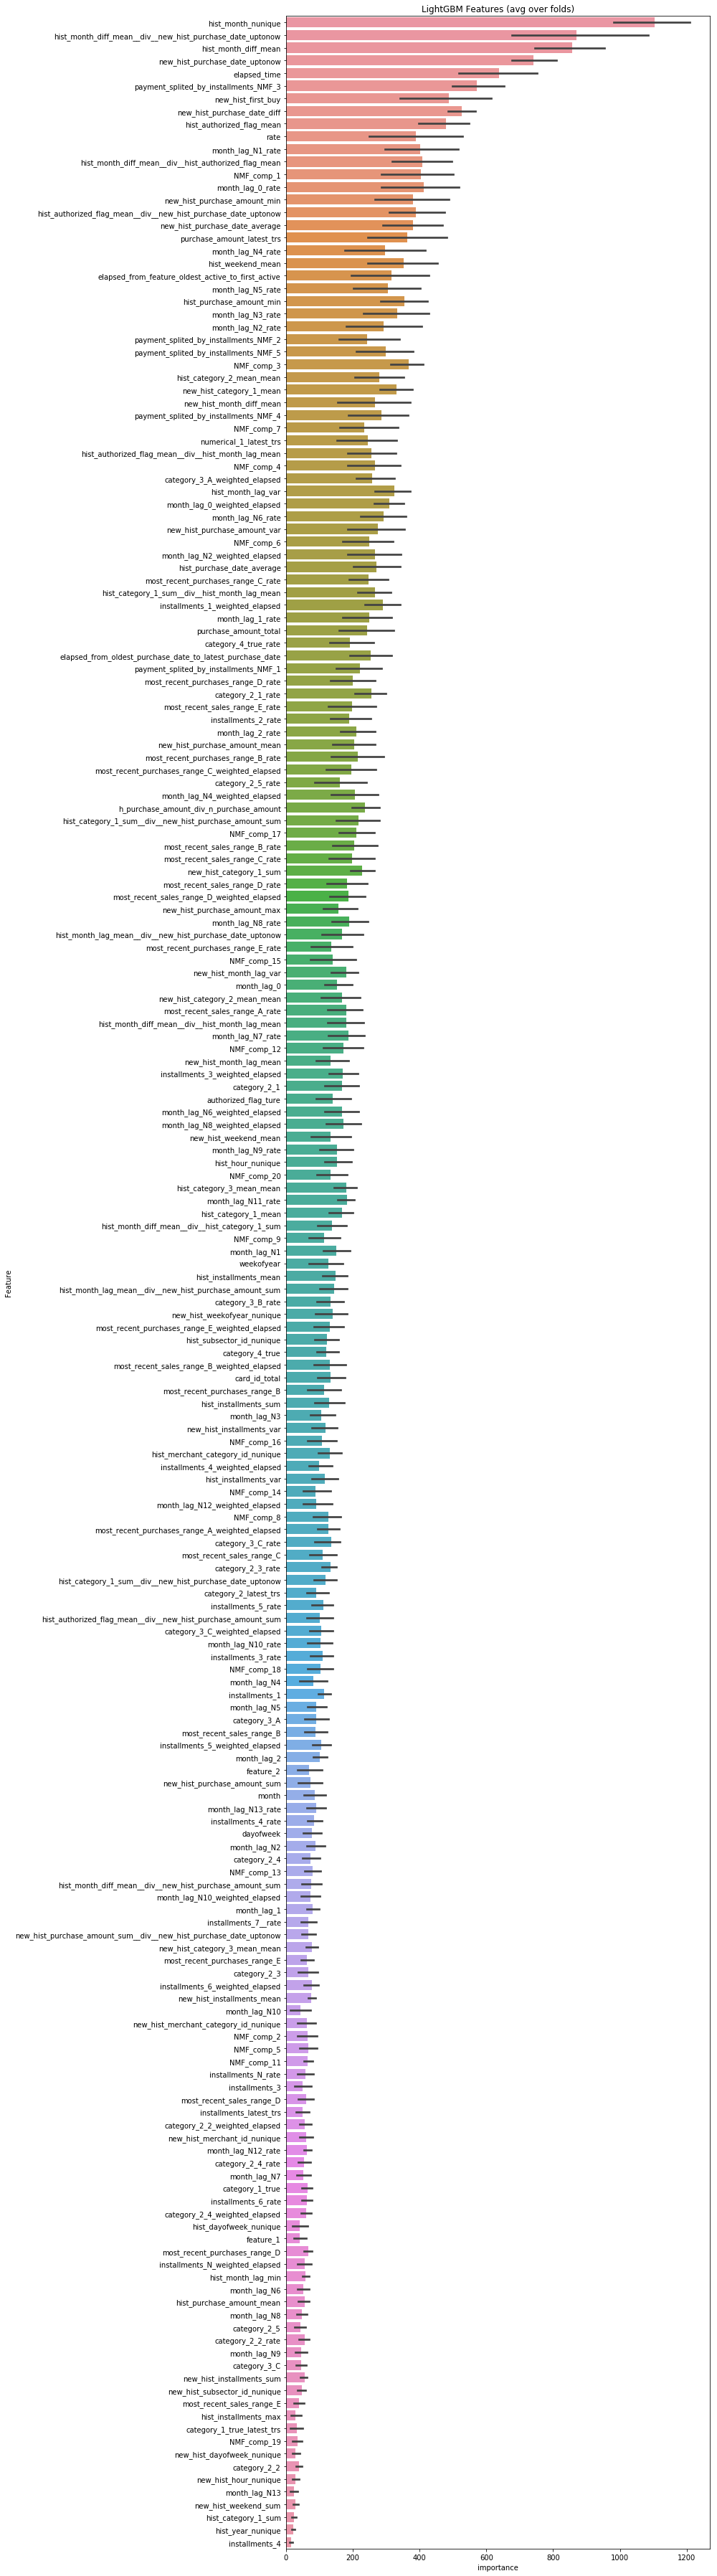

In [15]:
cols2 = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols2)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [16]:
for k in range(-30, 0, 1):
    rmse = []
    for i in [i/1000.0 for i in range(1,1001)]:
        predict_outliers = np.where(oof>i, k, 0)
        rmse.append(np.sqrt(mean_squared_error(target.values, predict_outliers)))
        if min(rmse) == rmse[-1]:
            best_th = i
    print("%d -- %f -- %f" %(k, min(rmse), best_th))

-30 -- 3.861662 -- 0.448000
-29 -- 3.860702 -- 0.445000
-28 -- 3.859803 -- 0.445000
-27 -- 3.858992 -- 0.445000
-26 -- 3.857389 -- 0.358000
-25 -- 3.854701 -- 0.358000
-24 -- 3.852268 -- 0.358000
-23 -- 3.850089 -- 0.358000
-22 -- 3.848165 -- 0.358000
-21 -- 3.844387 -- 0.242000
-20 -- 3.835733 -- 0.236000
-19 -- 3.827476 -- 0.236000
-18 -- 3.820259 -- 0.236000
-17 -- 3.814086 -- 0.236000
-16 -- 3.807531 -- 0.214000
-15 -- 3.801440 -- 0.214000
-14 -- 3.796616 -- 0.212000
-13 -- 3.792959 -- 0.212000
-12 -- 3.790685 -- 0.212000
-11 -- 3.788761 -- 0.197000
-10 -- 3.783769 -- 0.154000
-9 -- 3.776666 -- 0.105000
-8 -- 3.769776 -- 0.105000
-7 -- 3.766267 -- 0.098000
-6 -- 3.762623 -- 0.075000
-5 -- 3.763483 -- 0.075000
-4 -- 3.769588 -- 0.057000
-3 -- 3.773275 -- 0.037000
-2 -- 3.785675 -- 0.026000
-1 -- 3.814847 -- 0.018000


In [17]:
df_predict = pd.read_csv("../output/submission_model20181216_20190217.csv")
df_no_outliers_predict = pd.read_csv("../output/submission_no_outliers_model20190217.csv")

In [18]:
df_predict = pd.merge(df_predict, df_no_outliers_predict, on="card_id", how="inner")

In [19]:
df_predict["target"] = np.where(df_predict.target_x.values < 0, df_predict.target_x, df_predict.target_y)

del df_predict["target_x"]
del df_predict["target_y"]

In [27]:
outliers_idx = np.where(predictions>0.41)[0]
outliers_idx.shape

(57,)

In [21]:
df_predict["target"].iloc[outliers_idx] = -27

In [22]:
df_predict[df_predict.target == -27]

,card_id,target
2624,C_ID_bd59e054f3,-27.0
4618,C_ID_c21e877db3,-27.0
5008,C_ID_be92f84f5c,-27.0
5009,C_ID_695b445408,-27.0
5656,C_ID_126a403be9,-27.0
6026,C_ID_91cc0c06ca,-27.0
16074,C_ID_9c760806b5,-27.0
18363,C_ID_d2871ae781,-27.0
19114,C_ID_0be3fb41d2,-27.0
20556,C_ID_aae50409e7,-27.0


In [23]:
df_predict[["card_id", "target"]].to_csv("../output/submission_model20190213.csv", index=False)